<a href="https://colab.research.google.com/github/keesterbrugge/rl_intro_sutton/blob/main/ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.5

In [109]:
# 2.5 
import numpy as np
import random
from numba import njit

def bandit_sim(n_iterations=100, n_sims = 10, n_actions = 3 ,
               epsilon = 0.1,
               innovation_scale = 0.01,
               q_star_start_scale = 0,
               alpha = None, 
               q_init = 0,
               N_init = 0,
               use_beta = False,
               ):
    
  A = np.arange(n_actions)
  R = np.zeros((n_sims, n_iterations))
  Q_avg = np.zeros((n_sims, n_iterations))
  is_action_best=np.zeros((n_sims, n_iterations))
  is_action_best_mean = np.zeros(n_iterations)
  R_mean = np.zeros(n_iterations)
  Q_avg_mean = np.zeros(n_iterations)


  for s in range(n_sims):
    Q = np.ones(n_actions) * q_init
    N = np.ones(n_actions) * N_init
    #q_star = np.zeros(n_actions)
    q_star = np.random.normal(loc=0, scale=q_star_start_scale, size=n_actions)
    o_bar = np.zeros(n_actions)

    for i in range(n_iterations):
      ids =  A if random.random() < epsilon else  A[Q == np.max(Q)]
      action = np.random.choice(ids)
      R[s, i] = np.random.normal(loc=q_star[action], scale=1)
      N[action] += 1
      # Q[action] += (R[s, i] - Q[action])/N[action]
      if alpha is not None:
        o_bar[action] += alpha * (1 - o_bar[action]) 
        stepsize = alpha/o_bar[action] if use_beta else alpha 
        Q[action] += stepsize * (R[s, i] - Q[action])
      else:
        Q[action] += (R[s, i] - Q[action])/N[action]
      q_star += np.random.normal(loc=0, scale=innovation_scale, size=q_star.size)
      is_action_best[s, i] = q_star[action] == q_star.max()
      Q_avg[s, i] = Q.mean()
  for i in range(n_iterations):
    is_action_best_mean[i] = is_action_best[:,i].mean()
    R_mean[i] = R[:,i].mean()
    Q_avg_mean[i] = Q_avg[:,i].mean()

  return( is_action_best_mean, R_mean, Q_avg_mean)  
  # return(is_action_best, R)

bandit_sim_jit = njit(bandit_sim)

In [93]:
%timeit bandit_sim(n_iterations=100, n_sims = 10)

70.1 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%timeit bandit_sim_jit(n_iterations=10000, n_sims = 1000)

522 ms ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
is_action_best_mean, R_mean, _ = bandit_sim_jit(n_iterations=10000, 
               n_sims = 1000, 
               n_actions = 3,
               epsilon = 0.1)

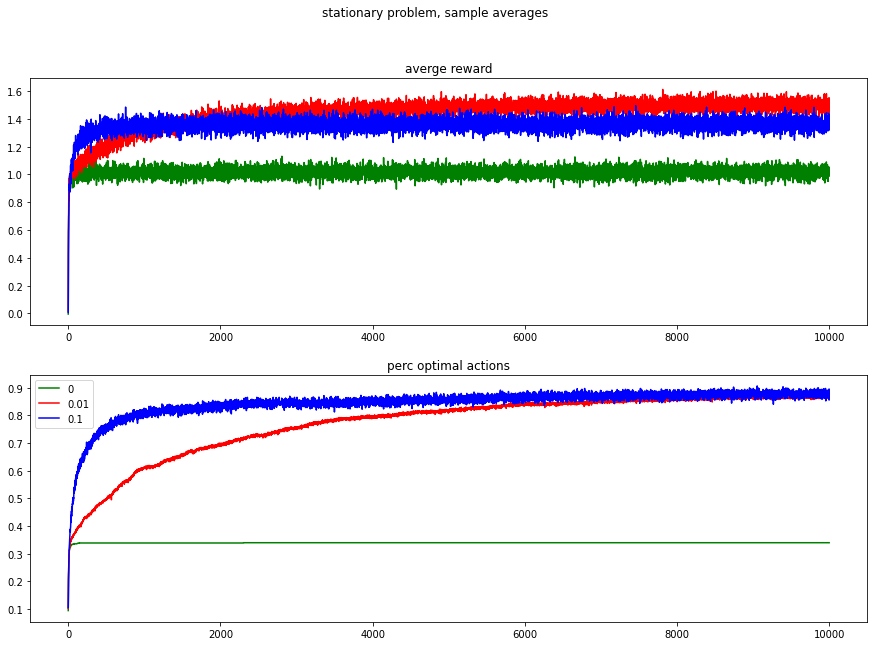

In [68]:
# recreation of figure 2.2
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, figsize=(15, 10))
fig.suptitle('stationary problem, sample averages')
axs[0].set_title("averge reward")
axs[1].set_title("perc optimal actions")
for color, eps in zip(["green", "red", "blue"], [0, 0.01, .1]):
  is_action_best_mean, R_mean, _ = bandit_sim_jit(
      n_iterations=10000, n_sims = 1000, n_actions = 10,
      epsilon = eps,
      innovation_scale = 0.0,
      q_star_start_scale = 1)

  axs[0].plot(np.arange(R_mean.size), R_mean, color=color, label = eps)
  axs[1].plot(np.arange(is_action_best_mean.size), is_action_best_mean, color = color, label = eps)
# is_action_best.mean(axis=0)
plt.legend()

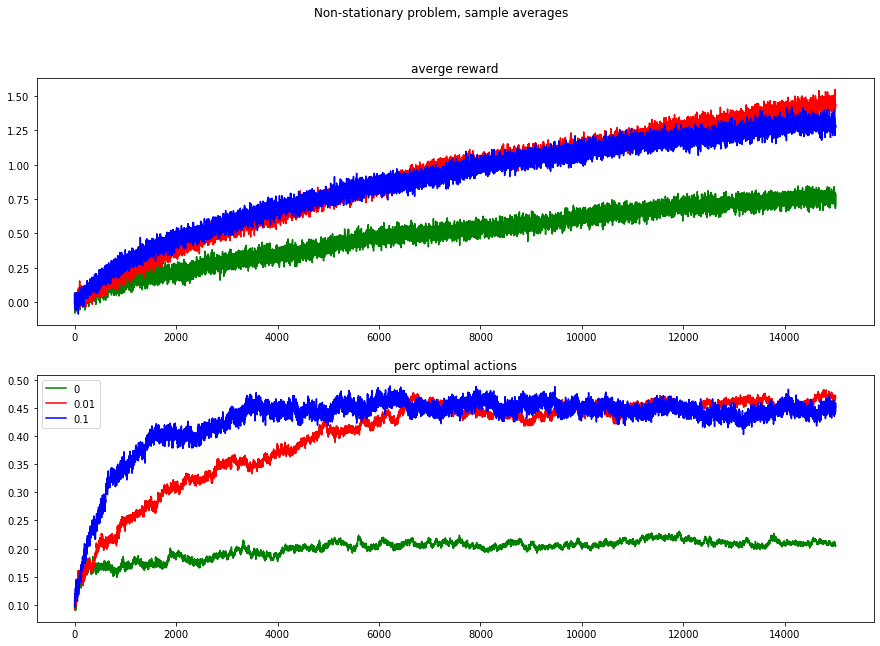

In [70]:
# exercise 2.5 

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, figsize=(15, 10))
fig.suptitle("Non-stationary problem, sample averages")
axs[0].set_title("averge reward")
axs[1].set_title("perc optimal actions")
for color, eps in zip(["green", "red", "blue"], [0, 0.01, .1]):
  is_action_best_mean, R_mean, _ = bandit_sim_jit(
      n_iterations=15000, n_sims = 1000, n_actions = 10,
      epsilon = eps,
      innovation_scale = 0.01, # every step innovation to q_star
      q_star_start_scale = 0 # all q_star start out equal
      )
  
  axs[0].plot(np.arange(R_mean.size), R_mean, color=color, label = eps)
  axs[1].plot(np.arange(is_action_best_mean.size), is_action_best_mean, color = color, label = eps)
# is_action_best.mean(axis=0)
plt.legend()

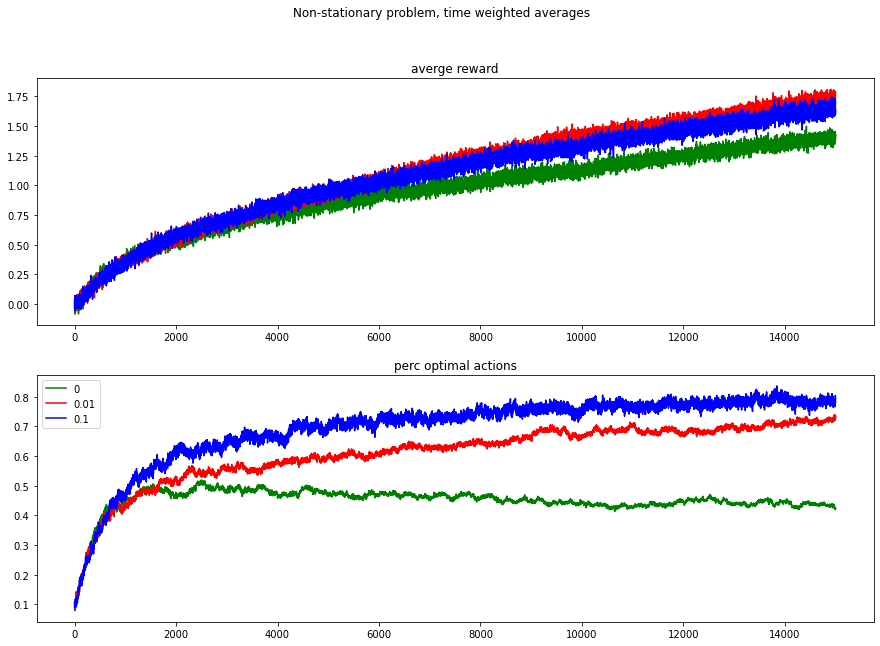

In [81]:
# exercise 2.5 

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, figsize=(15, 10))
fig.suptitle("Non-stationary problem, time weighted averages")
axs[0].set_title("averge reward")
axs[1].set_title("perc optimal actions")
for color, eps in zip(["green", "red", "blue"], [0, 0.01, .1]):
  is_action_best_mean, R_mean, _ = bandit_sim_jit(
      n_iterations=15000, n_sims = 1000, n_actions = 10,
      epsilon = eps,
      innovation_scale = 0.01, # every step innovation to q_star
      q_star_start_scale = 0, # all q_star start out equal
      alpha = 0.1, # so instead of sample average now we weight recent examples
      #  heavier than earlier 
      )
  
  axs[0].plot(np.arange(R_mean.size), R_mean, color=color, label = eps)
  axs[1].plot(np.arange(is_action_best_mean.size), is_action_best_mean, color = color, label = eps)
# is_action_best.mean(axis=0)
plt.legend()

## observations

with time weighted averages, only greedy stays under 50 % optimal action, the others go up to 80 %
In the sample average case none of the 3 go above 50 %

Second observation is that even though the perc of optimal actions of red (eps = 0.01) is lower than blue, still the average reward of red is slightly higher. that's probably because it has to explore a suboptimal action less often.



# 2.6

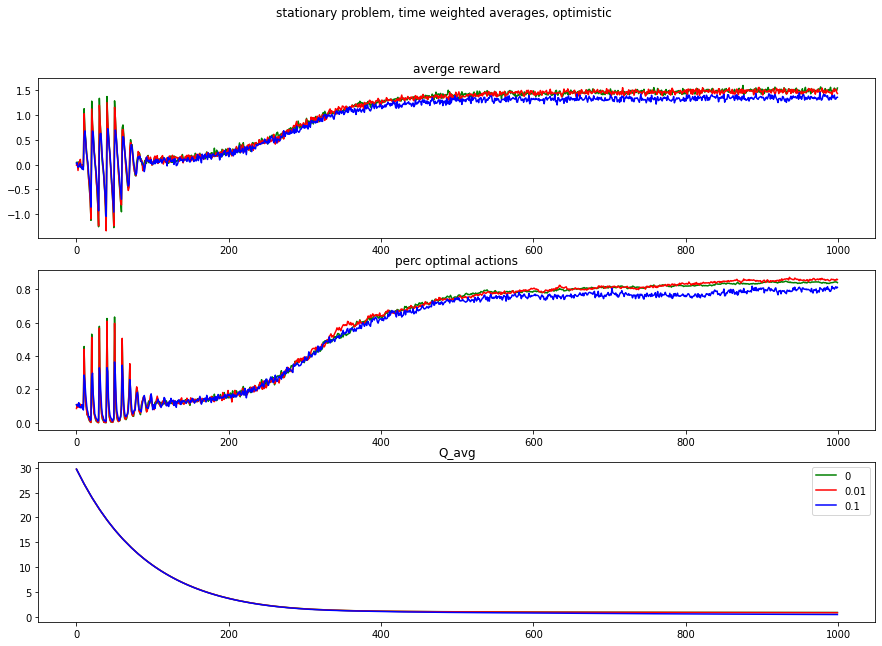

In [100]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, figsize=(15, 10))
fig.suptitle('stationary problem, time weighted averages, optimistic')
axs[0].set_title("averge reward")
axs[1].set_title("perc optimal actions")
axs[2].set_title("Q_avg")

for color, eps in zip(["green", "red", "blue"], [0, 0.01, .1]):
  is_action_best_mean, R_mean, Q_avg_mean = bandit_sim_jit(
      n_iterations=1000, n_sims = 1000, n_actions = 10,
      epsilon = eps,
      alpha = 0.1, 
      innovation_scale = 0.0,
      q_star_start_scale = 1,
      q_init = 30)

  axs[0].plot(np.arange(R_mean.size), R_mean, color=color, label = eps)
  axs[1].plot(np.arange(R_mean.size), is_action_best_mean, color = color, label = eps)
  axs[2].plot(np.arange(R_mean.size), Q_avg_mean, color = color, label = eps)
# is_action_best.mean(axis=0)
plt.legend()

Made much worse by higher $Q_0$

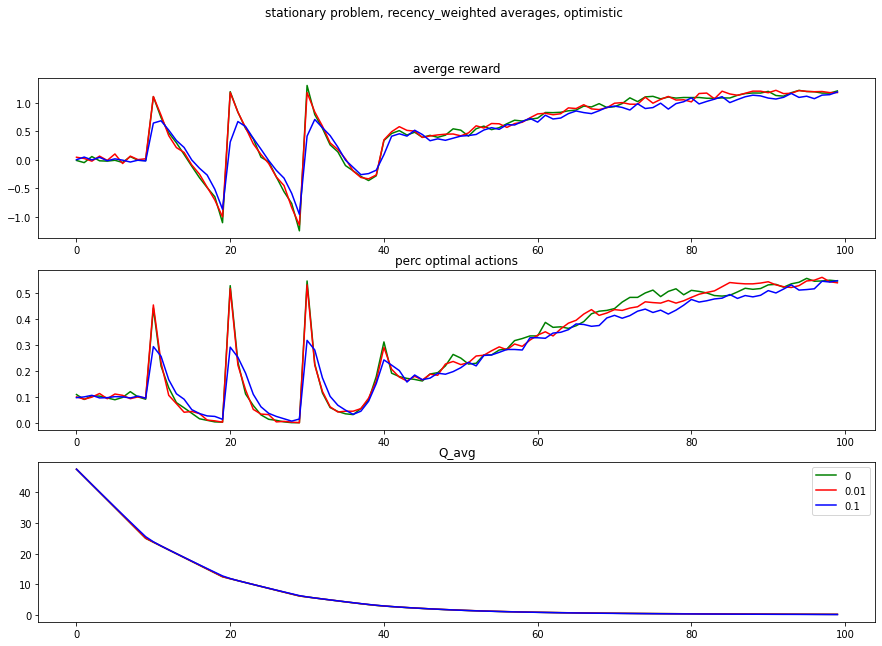

In [110]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, figsize=(15, 10))
fig.suptitle('stationary problem, recency_weighted averages, optimistic')
axs[0].set_title("averge reward")
axs[1].set_title("perc optimal actions")
axs[2].set_title("Q_avg")

for color, eps in zip(["green", "red", "blue"], [0, 0.01, .1]):
  is_action_best_mean, R_mean, Q_avg_mean = bandit_sim_jit(
      n_iterations=100, n_sims = 1000, n_actions = 10,
      epsilon = eps,
      alpha = .5, 
      innovation_scale = 0.0,
      q_star_start_scale = 1,
      q_init = 50)

  axs[0].plot(np.arange(R_mean.size), R_mean, color=color, label = eps)
  axs[1].plot(np.arange(R_mean.size), is_action_best_mean, color = color, label = eps)
  axs[2].plot(np.arange(R_mean.size), Q_avg_mean, color = color, label = eps)
# is_action_best.mean(axis=0)
plt.legend()

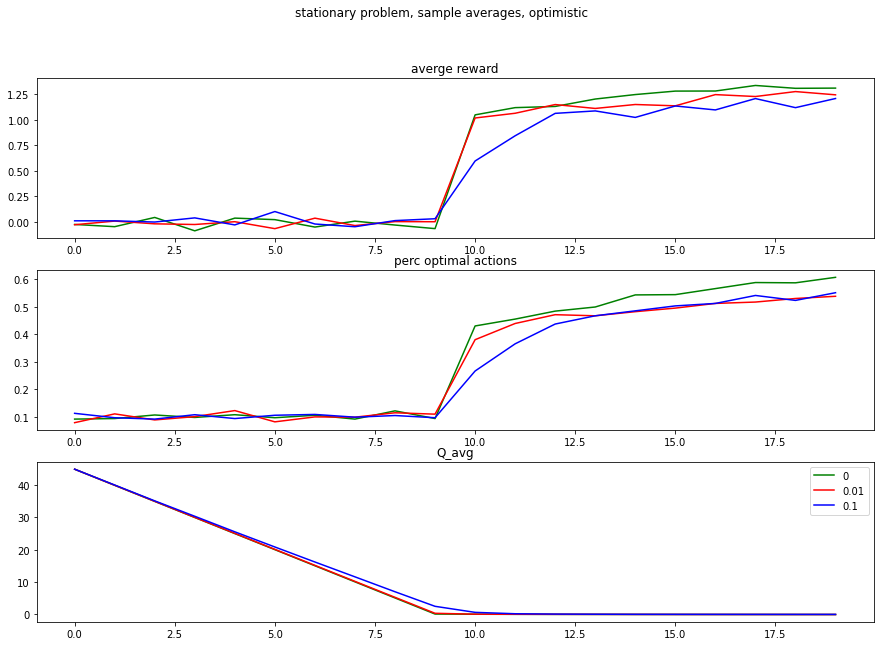

In [105]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, figsize=(15, 10))
fig.suptitle('stationary problem, sample averages, optimistic')
axs[0].set_title("averge reward")
axs[1].set_title("perc optimal actions")
axs[2].set_title("Q_avg")

for color, eps in zip(["green", "red", "blue"], [0, 0.01, .1]):
  is_action_best_mean, R_mean, Q_avg_mean = bandit_sim_jit(
      n_iterations=20, n_sims = 1000, n_actions = 10,
      epsilon = eps,
      alpha = None, 
      innovation_scale = 0.0,
      q_star_start_scale = 1,
      q_init = 50)

  axs[0].plot(np.arange(R_mean.size), R_mean, color=color, label = eps)
  axs[1].plot(np.arange(R_mean.size), is_action_best_mean, color = color, label = eps)
  axs[2].plot(np.arange(R_mean.size), Q_avg_mean, color = color, label = eps)
# is_action_best.mean(axis=0)
plt.legend()

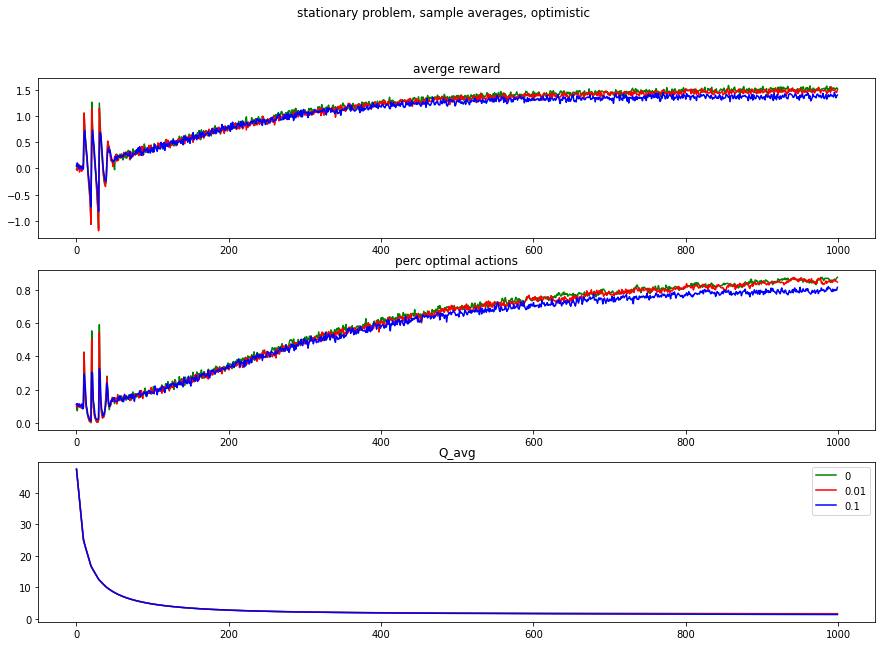

In [108]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, figsize=(15, 10))
fig.suptitle('stationary problem, sample averages, optimistic')
axs[0].set_title("averge reward")
axs[1].set_title("perc optimal actions")
axs[2].set_title("Q_avg")

for color, eps in zip(["green", "red", "blue"], [0, 0.01, .1]):
  is_action_best_mean, R_mean, Q_avg_mean = bandit_sim_jit(
      n_iterations=1000, n_sims = 1000, n_actions = 10,
      epsilon = eps,
      alpha = None, 
      innovation_scale = 0.0,
      q_star_start_scale = 1,
      q_init = 50,
      N_init = 1)

  axs[0].plot(np.arange(R_mean.size), R_mean, color=color, label = eps)
  axs[1].plot(np.arange(R_mean.size), is_action_best_mean, color = color, label = eps)
  axs[2].plot(np.arange(R_mean.size), Q_avg_mean, color = color, label = eps)
# is_action_best.mean(axis=0)
plt.legend()

## observations

It just takes mcuh longer for high optimistic values to drop in the time weightee sample average as compared to the case with sample average. The initial steps are way bigger with sample avg. So it takes over 200 steps in time weighted for optimistic  Q_avg to come down vs 

# 2.7

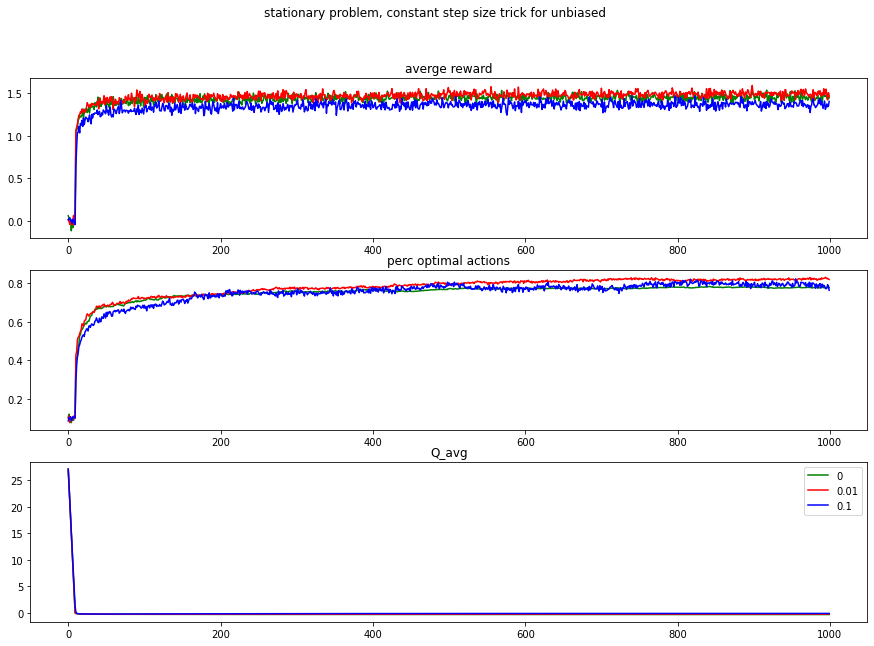

In [113]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, figsize=(15, 10))
fig.suptitle('stationary problem, constant step size trick for unbiased')
axs[0].set_title("averge reward")
axs[1].set_title("perc optimal actions")
axs[2].set_title("Q_avg")

for color, eps in zip(["green", "red", "blue"], [0, 0.01, .1]):
  is_action_best_mean, R_mean, Q_avg_mean = bandit_sim_jit(
      n_iterations=1000, n_sims = 1000, n_actions = 10,
      epsilon = eps,
      alpha = 0.1, 
      innovation_scale = 0.0,
      q_star_start_scale = 1,
      q_init = 30,
      use_beta=True)

  axs[0].plot(np.arange(R_mean.size), R_mean, color=color, label = eps)
  axs[1].plot(np.arange(R_mean.size), is_action_best_mean, color = color, label = eps)
  axs[2].plot(np.arange(R_mean.size), Q_avg_mean, color = color, label = eps)
# is_action_best.mean(axis=0)
plt.legend()

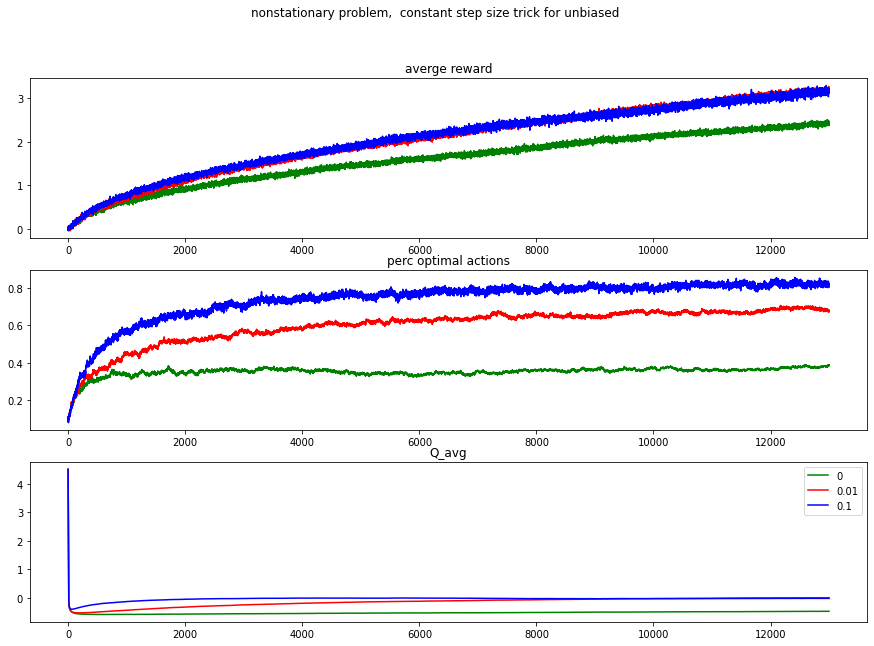

In [118]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, figsize=(15, 10))
fig.suptitle('nonstationary problem,  constant step size trick for unbiased')
axs[0].set_title("averge reward")
axs[1].set_title("perc optimal actions")
axs[2].set_title("Q_avg")

for color, eps in zip(["green", "red", "blue"], [0, 0.01, .1]):
  is_action_best_mean, R_mean, Q_avg_mean = bandit_sim_jit(
      n_iterations=13000, n_sims = 1000, n_actions = 10,
      epsilon = eps,
      alpha = 0.1, 
      innovation_scale = 0.02, # nonstationary
      q_star_start_scale = 0, # all from 0
      q_init = 5,
      use_beta=True)

  axs[0].plot(np.arange(R_mean.size), R_mean, color=color, label = eps)
  axs[1].plot(np.arange(R_mean.size), is_action_best_mean, color = color, label = eps)
  axs[2].plot(np.arange(R_mean.size), Q_avg_mean, color = color, label = eps)
# is_action_best.mean(axis=0)
plt.legend()

So indeed bias is gone after first iteration. Maybe you want to keep bias around
for a bit longer. Perhaps there's still something in between this and constant step size alpha

New trick retains property of being able to pick out winning action more than 50 percent of the time, towards 80 %. 

What about speed of change? The nonstationarity? Impact?




# 2.11

In [84]:
help(np.random.choice)

Help on built-in function choice:

choice(...) method of numpy.random.mtrand.RandomState instance
    choice(a, size=None, replace=True, p=None)
    
    Generates a random sample from a given 1-D array
    
    .. versionadded:: 1.7.0
    
    .. note::
        New code should use the ``choice`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    a : 1-D array-like or int
        If an ndarray, a random sample is generated from its elements.
        If an int, the random sample is generated as if it were ``np.arange(a)``
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    replace : boolean, optional
        Whether the sample is with or without replacement. Default is True,
        meaning that a value of ``a`` can be selected mu

In [161]:
np.exp(np.array([2,3]))

array([ 7.3890561 , 20.08553692])

In [169]:

import numpy as np
import random
from numba import njit

def bandit_sim_lean(n_iterations=100, n_sims = 100, n_actions = 3 ,
               epsilon = 0.1,
               innovation_scale = 0.01,
               q_star_start_scale = 0,
               alpha = None, 
               c = None,
               q_init = 0,
               N_init = 0,
               use_beta = False,
               use_gradient_bandit = False,
               end_result_min_i = 50000,
               verbose = False,
               ):
    
  A = np.arange(n_actions)
  end_result_counter = 0
  end_result_sum = 0
  # end_result_min_i = 50000

  for s in range(n_sims):
    Q = np.ones(n_actions) * q_init
    N = np.ones(n_actions) * N_init
    #q_star = np.zeros(n_actions)
    q_star = np.random.normal(loc=0, scale=q_star_start_scale, size=n_actions)
    o_bar = np.zeros(n_actions)

    for i in range(n_iterations):
  
      if epsilon is not None:
        ids =  A if random.random() < epsilon else  A[Q == np.max(Q)]
        action = np.random.choice(ids)
      elif c is not None:
        Q_adj = Q + c * np.sqrt(np.log(i+1)/(N + .000001))
        ids = A[Q_adj == np.max(Q_adj)]
        action = np.random.choice(ids)
      elif use_gradient_bandit:
        ids = A
        p = np.exp(Q) / np.sum(np.exp(Q))

        p_cumsum = np.cumsum(p)
        r = random.random()
        for a in A:
          action = a 
          if p_cumsum[a] > r: 
            break
        if verbose:        print(p_cumsum)
        # multin_draw = np.random.multinomial(n = 1, pvals = p)
        # if verbose: print(multin_draw)
        # action = np.argmax(multin_draw) 
        if verbose: print(action)


      reward = np.random.normal(loc=q_star[action], scale=1)
      # R[s, i] = np.random.normal(loc=q_star[action], scale=1)
      N[action] += 1
      # Q[action] += (R[s, i] - Q[action])/N[action]
      if alpha is not None:
        o_bar[action] += alpha * (1 - o_bar[action]) 
        stepsize = alpha/o_bar[action] if use_beta else alpha 
        baseline = np.multiply(Q, N).sum() / N.sum() if use_gradient_bandit else Q[action]
        Q[action] += stepsize * (reward - Q[action])
      else:
        Q[action] += (reward - Q[action])/N[action]
      q_star += np.random.normal(loc=0, scale=innovation_scale, size=q_star.size)
      
 
      end_result_counter += 1 if i >= end_result_min_i else 0
      end_result_sum += reward if i >= end_result_min_i else 0

      if verbose: print(end_result_counter, end_result_sum)

  return(end_result_sum/end_result_counter)  
  # return(is_action_best, R)

bandit_sim_lean_jit = njit(bandit_sim_lean)

bandit = partial(bandit_sim_lean_jit,
        n_iterations=100000, n_sims = 100, n_actions = 10,
        epsilon = None,
        alpha = None,
        innovation_scale = 0.01, # nonstationary
        q_star_start_scale = 0, # all from 0
        q_init = 0,
        use_beta=False)

In [170]:
bandit_sim_lean_jit(n_iterations=10, n_sims = 1, n_actions = 10 ,
               epsilon = None,
               innovation_scale = 0.01,
               q_star_start_scale = 0,
               alpha = None, 
               c = None,
               q_init = 0,
               N_init = 0,
               use_beta = False,
               use_gradient_bandit = True,
               end_result_min_i = 3,
               verbose=True
               )


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
3
0 0.0
[0.10246578 0.20493155 0.30739733 0.38520534 0.48767111 0.59013689
 0.69260267 0.79506845 0.89753422 1.        ]
3
0 0.0
[0.1075403  0.2150806  0.3226209  0.35475819 0.4622985  0.5698388
 0.6773791  0.7849194  0.8924597  1.        ]
2
0 0.0
[0.10708809 0.21417618 0.3254693  0.35747146 0.46455955 0.57164764
 0.67873573 0.78582382 0.89291191 1.        ]
0
1 1.2485499233620265
[0.29477881 0.3793569  0.46725613 0.49253141 0.57710951 0.66168761
 0.74626571 0.8308438  0.9154219  1.        ]
5
2 3.3348394744990038
[0.18461798 0.23758867 0.29263936 0.3084691  0.36143979 0.78811723
 0.84108792 0.89405862 0.94702931 1.        ]
5
3 3.424858061295596
[0.25270009 0.32520494 0.40055684 0.42222416 0.49472901 0.7099806
 0.78248545 0.8549903  0.92749515 1.        ]
8
4 4.755653551867893
[0.21025798 0.27058532 0.33328153 0.35130973 0.41163706 0.59073619
 0.65106352 0.71139086 0.93967266 1.        ]
8
5 5.325035759792058
[0.22663923 0.29166669 0.35924758

0.8498142252929778

In [129]:
from functools import partial

In [163]:
Q = np.array([2,3,400])

np.exp(Q)/np.sum(np.exp(Q))

array([1.41512956e-173, 3.84672096e-173, 1.00000000e+000])

In [166]:
np.exp(Q - np.log(np.sum(np.exp(Q))))

array([1.41512956e-173, 3.84672096e-173, 1.00000000e+000])

In [26]:
eps_greedy_results = []
for exponent in range(-6, -2):
  eps = 2**exponent

  avg_reward = bandit(
      epsilon=eps
  )
  
  eps_greedy_results.append([eps, avg_reward])


25290633.0046672
9990000
26311889.62145499
9990000
23563729.381681345
9990000
21519569.751844086
9990000


In [39]:
eps_greedy_optimistic_results = []
for exponent in range(-1, 4):
  val = 2**exponent

  avg_reward = bandit(
      epsilon=0.1,
      alpha=0.1,
      q_init=5
  )
  
  eps_greedy_optimistic_results.append([val, avg_reward])


In [173]:
ucb_results = []
for exponent in range(-2, 8):
  val = 2**exponent

  avg_reward = bandit(
      epsilon=None,
      c = val,
  )
  # avg_reward = bandit_sim_lean(
  #       n_iterations=50001, n_sims = 1, n_actions = 10,
  #       epsilon = None,
  #       alpha = None,
  #       innovation_scale = 0.01, # nonstationary
  #       q_star_start_scale = 0, # all from 0
  #       q_init = 0,
  #       use_beta=False,
  #       c = .3)
  
  ucb_results.append([val, avg_reward])

In [171]:
grad_desc_results = []
for exponent in range(-3, 3):
  val = 2**exponent

  avg_reward = bandit(
      alpha = val,
      use_gradient_bandit=True,
  )
  # avg_reward = bandit_sim_lean(
  #       n_iterations=50001, n_sims = 1, n_actions = 10,
  #       epsilon = None,
  #       alpha = None,
  #       innovation_scale = 0.01, # nonstationary
  #       q_star_start_scale = 0, # all from 0
  #       q_init = 0,
  #       use_beta=False,
  #       c = .3)
  
  grad_desc_results.append([val, avg_reward])

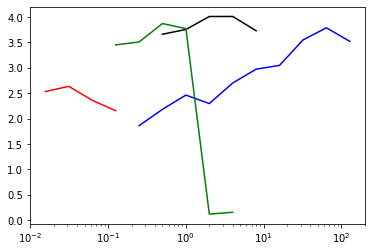

In [174]:
import matplotlib.pyplot as plt 
plt.plot(np.array(eps_greedy_results)[:,0], np.array(eps_greedy_results)[:,1], color="red")
plt.plot(np.array(eps_greedy_optimistic_results)[:,0], np.array(eps_greedy_optimistic_results)[:,1], color="black")
plt.plot(np.array(ucb_results)[:,0], np.array(ucb_results)[:,1], color="blue")
plt.plot(np.array(grad_desc_results)[:,0], np.array(grad_desc_results)[:,1], color="green")
plt.xscale("log")

In [32]:
np.array(eps_greedy_results)[:,1]

array([2.5315949 , 2.63382278, 2.35873167, 2.15411109])

## observation
Much time was lost implementing this in numba. Too slow otherwise and many numerical issues and missing implementations,
e.g. no p kwarg in np.random.choice
numerical instability when using np.random.multinomial :/

This took too much time, consider doing less iterations or use jax :D